# Mixture of Compound Gaussians 

Compound Gaussian is a more general class of distributions that can be expressed as

$$X = \mu + \sqrt{\tau} A g$$

with $\tau \geq 0$ random variable, $g\sim \mathcal{N}(0, I)$, $AA^T=\Sigma$ 

$X_i|\tau=\tau_i \sim \mathcal{N}(\mu_j,\tau_i \Sigma_j)$

We load the libraries

In [1]:
import numpy as np
import random 
import pandas as pd
import os
import time
import csv 
import warnings

# MATH and STATS:
import math
from scipy.stats import t
from scipy.stats import multivariate_normal
from scipy.special import gamma

# PLOT:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # 3D
from plotnine import *
from plotnine.data import *
%matplotlib inline

# SKLEARN:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
import sklearn.datasets
from sklearn import metrics # AMII and ARI
from sklearn import decomposition #PCA

import umap

In [8]:
from _fem import *
from import_subset_datasets import *
from clustering_accuracy import *

In [35]:
warnings.filterwarnings('ignore') # AMI warning

### NORB dataset

In [11]:
from smallnorb import *

Import all data (don't run multiple times)

In [12]:
NORB = SmallNORBDataset(dataset_root='./data/')

datiss = NORB._parse_NORB_dat_file('data/smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat')
NORB_datos = np.reshape(datiss, (48600, 9216,)) #each image in a row
NORB_datos_lt = NORB_datos[::2, :] #only left image

NORB_labels = NORB._parse_NORB_cat_file('data/smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat')

Loading categories...: 100%|██████████| 24300/24300 [00:00<00:00, 867757.48it/s]


In [36]:
NORB_datos_lt = NORB_datos[::2, :] #only left image

NORB_labels = NORB._parse_NORB_cat_file('data/smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat')

Loading categories...: 100%|██████████| 24300/24300 [00:00<00:00, 506238.92it/s]


Select subset of categories, number of samples and PCA 

In [37]:
np.random.seed(44)
random.seed(44)

#categories = ['human', 'airplane', 'truck', 'car']
selected_cat = [1, 2, 3, 4]
n_sample = 400
n_pca = 30

#NORB_norm = NORB_datos_lt - NORB_datos_lt.mean(axis=1).reshape(-1, 1) 

NORB_datos_lt = pd.DataFrame(NORB_datos_lt)
#NORB_datos_lt = pd.DataFrame(NORB_norm)

NORB_pca, NORB_labels_sel, NORB_raw, ve = import_subset(NORB_datos_lt, NORB_labels, selected_cat, 30, 400)

Plot to check

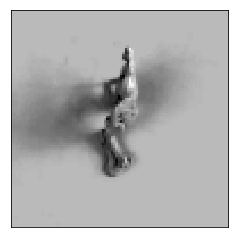

In [16]:
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,   
    left=False,
    labelleft=False,
    labelbottom=False)
plt.imshow(np.reshape(1-np.array(NORB_raw.iloc[100])/255, (96, 96)), cmap="binary")

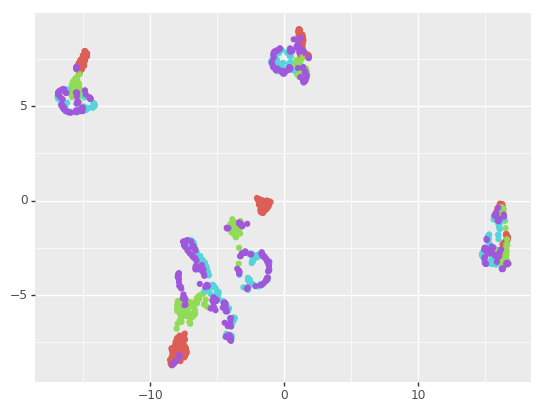

<ggplot: (183315826110)>

In [38]:
embedding = umap.UMAP(random_state = 44, metric='euclidean').fit_transform(NORB_pca)

label = pd.Series(NORB_labels_sel)
em = pd.DataFrame(embedding, columns=['A','B']) 
em['real labels'] = label.astype(str)
ggplot(aes(x='A', y='B', color='real labels'), data=em)+geom_point()+ylab("")+xlab("")+ scale_color_discrete(guide=False)

0.0012046114021813364
0.0015266393680895723
0.2725


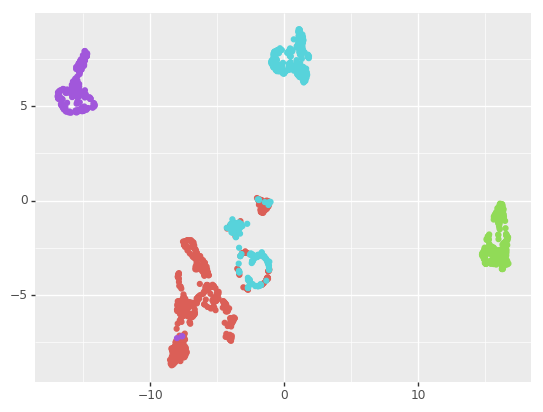

<ggplot: (-9223371853597505550)>

In [19]:
nrep = 100
kmeans_AMI = np.zeros((nrep, ))
kmeans_ARI = np.zeros((nrep, ))
kmeans_ACC = np.zeros((nrep, ))

for rep in range(nrep):

    kmeans = KMeans(n_clusters=4).fit(NORB_pca)
    kmeans_ARI[rep] = metrics.adjusted_rand_score(label, kmeans.labels_.astype(str))
    kmeans_AMI[rep] = metrics.adjusted_mutual_info_score(label, kmeans.labels_.astype(str))
    kmeans_ACC[rep] = acc(label, kmeans.labels_.astype(int))
    
print(np.median(kmeans_AMI))
print(np.median(kmeans_ARI))
print(np.median(kmeans_ACC))

em['kmeans'] = pd.Series(kmeans.labels_.astype(str))
em['label'] = pd.Series(NORB_labels_sel)
ggplot(em, aes(x='A',y='B',color='kmeans'))+geom_point()+ scale_color_discrete(guide=False)+ylab("")+xlab("")

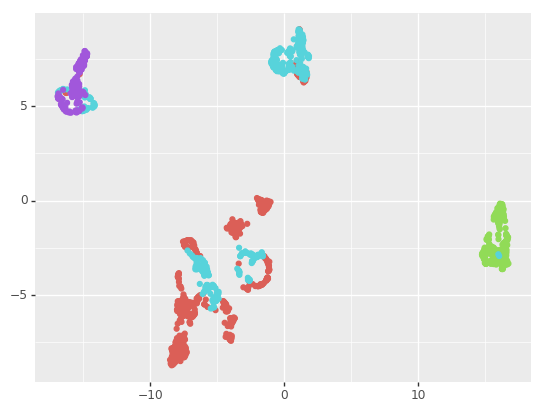

<ggplot: (-9223371853538949646)>

In [39]:
gmm = GaussianMixture(n_components=4).fit(NORB_pca)
labels_gmm = gmm.predict(NORB_pca)
em['gmm'] = pd.Series(labels_gmm.astype(str))
ggplot(em, aes(x='A',y='B',color='gmm'))+geom_point()+ylab("")+xlab("")+ scale_color_discrete(guide=False)

In [40]:
print('AMI GMM: ', metrics.adjusted_mutual_info_score(NORB_labels_sel, labels_gmm))
print('ARI GMM: ', metrics.adjusted_rand_score(NORB_labels_sel, labels_gmm))
print('ACU: ', acc(NORB_labels_sel, labels_gmm))

AMI GMM:  0.047640345058035806
ARI GMM:  0.046774082129247406
ACU:  0.343125


In [34]:
nrep = 10
frem_AMI = np.zeros((nrep, ))
frem_ARI = np.zeros((nrep, ))
frem_ACC = np.zeros((nrep, ))

for rep in range(nrep):
    fem = FEM(4).fit(NORB_pca)  
    labels_fem = fem.labels_ 

    frem_ARI[rep] = metrics.adjusted_rand_score(label, labels_fem.astype(str))
    frem_AMI[rep] = metrics.adjusted_mutual_info_score(label, labels_fem.astype(str))
    frem_ACC[rep] = acc(label.astype(int), labels_fem.astype(int))
    
print(np.median(frem_AMI))
print(np.median(frem_ARI))
print(np.median(frem_ACC))

0.39463358669499665
0.34108184046560064
0.44625


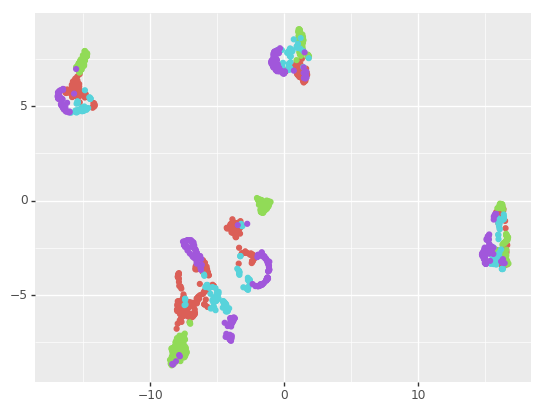

<ggplot: (154190229238)>

In [63]:
em['estimated'] = pd.Series(labels_fem.astype(str))
ggplot(em, aes(x='A',y='B',color='estimated'))+geom_point()+ylab("")+xlab("")+ scale_color_discrete(guide=False)

In [26]:
np.savetxt("NORB_pca.csv", NORB_pca, delimiter=",")
np.savetxt("NORB_raw.csv", NORB_raw, delimiter=",")
np.savetxt("NORB_labels_sel.csv", NORB_labels_sel, delimiter=",")

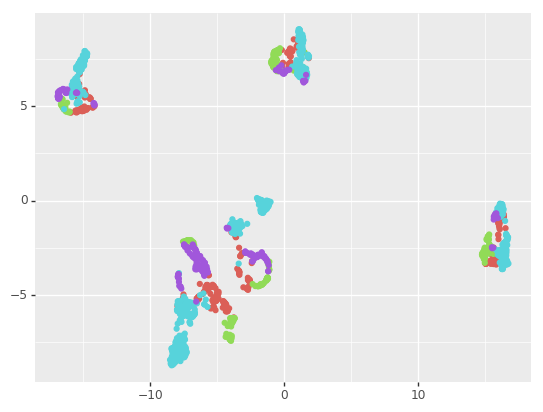

<ggplot: (-9223371850286979219)>

In [50]:
em['tmm'] = pd.Series(rlabels.astype(str))
ggplot(em, aes(x='A',y='B',color='tmm'))+geom_point()+ scale_color_discrete(guide=False)+ylab("")+xlab("")

In [56]:
rlabels = pd.read_csv("labels_frem_NORB.csv").values
nrep = 100
tEM_AMI = np.zeros((nrep, ))
tEM_ARI = np.zeros((nrep, ))
tEM_ACC = np.zeros((nrep, ))

for rep in range(nrep):

    tEM_labels = rlabels [rep, ]
    tEM_ARI[rep] = metrics.adjusted_rand_score(label, tEM_labels.astype(str))
    tEM_AMI[rep] = metrics.adjusted_mutual_info_score(label, tEM_labels.astype(str))
    tEM_ACC[rep] = acc(label, tEM_labels.astype(int))
    
print(np.median(tEM_AMI))
print(np.median(tEM_ARI))
print(np.median(tEM_ACC))


0.437051948410339
0.4223477825759734
0.6528125


In [52]:
print('AMI: ', metrics.adjusted_mutual_info_score(NORB_labels_sel, rlabels))
print('ARI: ', metrics.adjusted_rand_score(NORB_labels_sel, rlabels))
print('ACU: ', acc(NORB_labels_sel.astype(int), rlabels))

C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


AMI:  0.3715782361022036
ARI:  0.3120069153034319
ACU:  0.444375


AMI:  -0.0012817763567079014
AMI:  -0.0010496519153823177


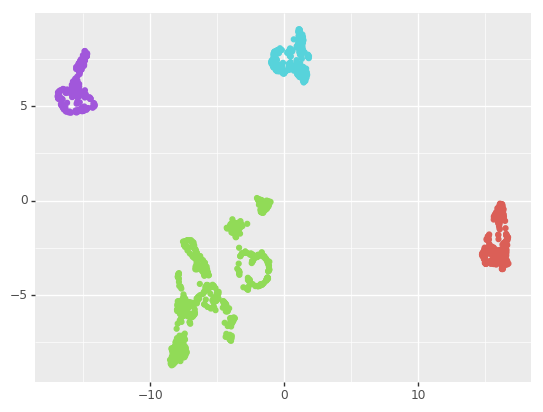

<ggplot: (183315934847)>

In [41]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters = 4, affinity= "nearest_neighbors", n_neighbors = 10)
spectral.fit(NORB_pca)  


print('AMI: ', metrics.adjusted_mutual_info_score(NORB_labels_sel, spectral.labels_.astype(str)))
print('AMI: ', metrics.adjusted_rand_score(NORB_labels_sel, spectral.labels_.astype(str)))
em['spec'] = pd.Series(spectral.labels_.astype(str))
ggplot(em, aes(x='A',y='B',color='spec'))+geom_point()+ scale_color_discrete(guide=False)+ylab("")+xlab("")

In [14]:
print('ACU: ', acc(NORB_labels_sel, spectral.labels_.astype(int)))

ACU:  0.26


## 20newsgroup

In [22]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

categories = ['sci.space',
    'talk.religion.misc',
    'rec.motorcycles',
    'comp.windows.x']

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=44)

labels = dataset.target
true_k = np.unique(labels).shape[0]

vectorizer = TfidfVectorizer(max_df=0.5, max_features=150,
                                 min_df=2, stop_words='english')

X = vectorizer.fit_transform(dataset.data)

XXdata  = pd.DataFrame(X.toarray())

In [27]:
news_pca, news_labels, news_raw, ve = import_subset(XXdata, labels, [0,1,2,3], 100, 500)

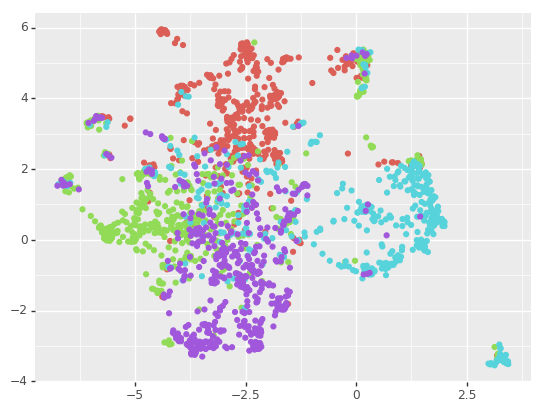

<ggplot: (183315756061)>

In [43]:
embedding = umap.UMAP(metric='euclidean', n_neighbors=20, min_dist=0.1).fit_transform(news_pca)
#embedding = umap.UMAP(random_state = 44, metric='euclidean').fit_transform(news_pca)

label = pd.Series(news_labels)
em = pd.DataFrame(embedding, columns=['A','B']) 
em['real labels'] = label.astype(str)
ggplot(aes(x='A', y='B', color='real labels'), data=em)+geom_point()+ylab("")+xlab("")+ scale_color_discrete(guide=False)

0.04282523362965886
AMI:  0.16813253302512282
AMI:  0.1010133170956377
ACC:  0.396


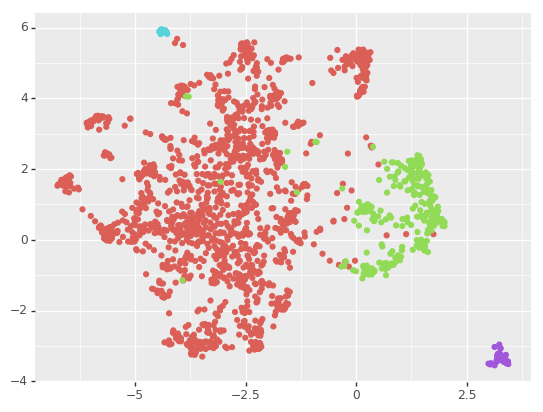

<ggplot: (183316030356)>

In [44]:
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters = 4, affinity= "nearest_neighbors", n_neighbors=11)
spectral.fit(news_pca)
print(sklearn.metrics.silhouette_score(news_pca, spectral.labels_))
print('AMI: ', metrics.adjusted_mutual_info_score(news_labels, spectral.labels_.astype(str)))
print('AMI: ', metrics.adjusted_rand_score(news_labels, spectral.labels_.astype(str)))
print('ACC: ', acc(label, spectral.labels_.astype(int)))

em['spec'] = pd.Series(spectral.labels_.astype(str))
ggplot(em, aes(x='A',y='B',color='spec'))+geom_point()+ scale_color_discrete(guide=False)+ylab("")+xlab("")

In [ ]:
import hdbscan

hdbis = hdbscan.HDBSCAN(min_cluster_size=10)
hdbis.fit(news_pca)
em['hdbs'] = hdbis.labels_.astype(str)
ggplot(aes(x='A', y='B', color='hdbs'), data=em)+geom_point()+ scale_color_discrete(guide=False) +xlab("")+ylab("")

0.4580331361396177
0.4477037394796627
0.719


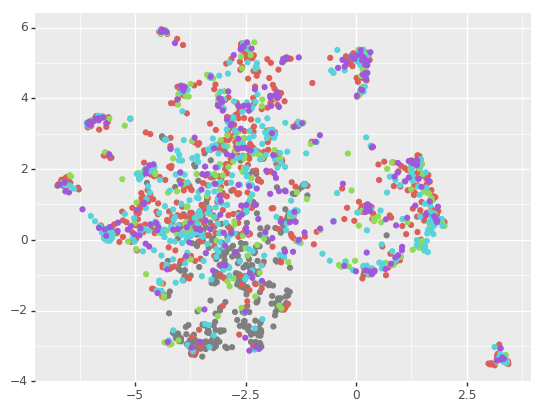

<ggplot: (183316379831)>

In [45]:
nrep = 100
kmeans_AMI = np.zeros((nrep, ))
kmeans_ARI = np.zeros((nrep, ))
kmeans_ACC = np.zeros((nrep, ))

for rep in range(nrep):

    gmm = GaussianMixture(n_components=4).fit(news_pca)
    labels_gmm = gmm.predict(news_pca)
    kmeans_ARI[rep] = metrics.adjusted_rand_score(label, labels_gmm.astype(str))
    kmeans_AMI[rep] = metrics.adjusted_mutual_info_score(label, labels_gmm.astype(str))
    kmeans_ACC[rep] = acc(label, labels_gmm.astype(int))
    
print(np.median(kmeans_AMI))
print(np.median(kmeans_ARI))
print(np.median(kmeans_ACC))

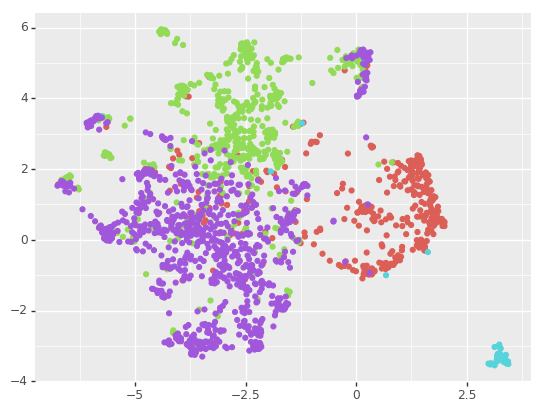

<ggplot: (183255495372)>

In [47]:
em['gmm'] = pd.Series(labels_gmm.astype(str))
ggplot(em, aes(x='A',y='B',color='gmm'))+geom_point()+ scale_color_discrete(guide=False)+ylab("")+xlab("")

In [30]:
nrep = 10
frem_AMI = np.zeros((nrep, ))
frem_ARI = np.zeros((nrep, ))
frem_ACC = np.zeros((nrep, ))

for rep in range(nrep):
    fem = FEM(4).fit(news_pca)  
    labels_fem = fem.labels_ 

    frem_ARI[rep] = metrics.adjusted_rand_score(label, labels_fem.astype(str))
    frem_AMI[rep] = metrics.adjusted_mutual_info_score(label, labels_fem.astype(str))
    frem_ACC[rep] = acc(label.astype(int), labels_fem.astype(int))
    
print(np.median(frem_AMI))
print(np.median(frem_ARI))
print(np.median(frem_ACC))

0.5046684584790897
0.5193632385022504
0.7785


In [60]:
np.savetxt("news_pca.csv", news_pca, delimiter=",")
np.savetxt("news_labels.csv", news_labels, delimiter=",")

In [18]:
rlabels = pd.read_csv("labels_frem_news.csv").values
nrep = 100
tEM_AMI = np.zeros((nrep, ))
tEM_ARI = np.zeros((nrep, ))
tEM_ACC = np.zeros((nrep, ))

for rep in range(nrep):

    tEM_labels = rlabels [rep, ]
    tEM_ARI[rep] = metrics.adjusted_rand_score(label, tEM_labels.astype(str))
    tEM_AMI[rep] = metrics.adjusted_mutual_info_score(label, tEM_labels.astype(str))
    tEM_ACC[rep] = acc(label, tEM_labels.astype(int))
    
print(np.median(tEM_AMI))
print(np.median(tEM_ARI))
print(np.median(tEM_ACC))


0.42466801365606566
0.4308640857915938
0.69
